Dataset link: https://www.kaggle.com/mlg-ulb/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we don't have the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

This kernel will compare various data balancing techniques with powerful boosting models. Models used here are Random Forest, XGBoost and LGB. We will look at precision-recall curve and roc curve.
###### Key Notes:
1. Dataset is highly imbalanced. Thus, we will work on both i.e., imbalanced and balanced dataset.
2. We will how precision-recall curve gives us more accurate details of the result as compare to roc curve.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("D:\CHIRAG\Credit card fraud detection\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


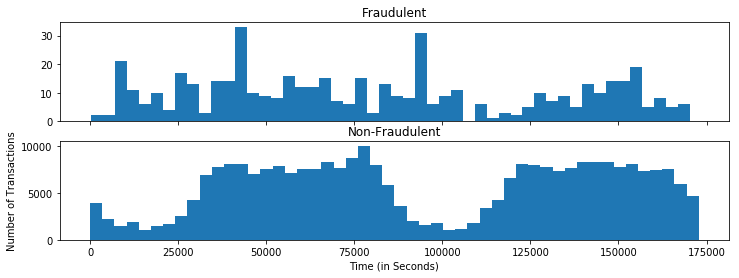

In [3]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Time[df.Class == 1], bins = 50)
ax1.set_title("Fraudulent")
ax2.hist(df.Time[df.Class == 0], bins = 50)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

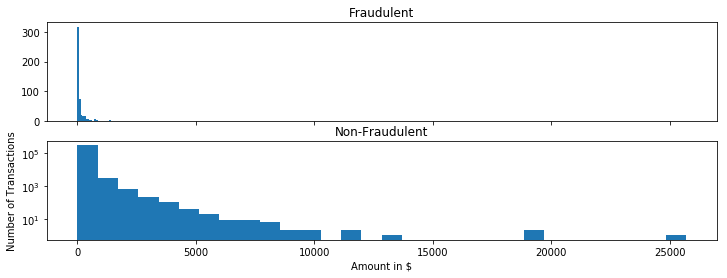

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Amount[df.Class == 1], bins = 30)
ax1.set_title("Fraudulent")
ax2.hist(df.Amount[df.Class == 0], bins = 30)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Amount in $')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Amount variable is skewed. So we will standardize it with mean = 0 and sd = 1.

In [5]:
df["Normalized_Amount"] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#Drop time & amount variable
df = df.drop(['Time', 'Amount'], axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [6]:
Class = [len(df.loc[df.Class == 1]), len(df.loc[df.Class == 0])]
pd.Series(Class, index = ['Fraudulent', 'Non-fraudulent'], name = 'target')

Fraudulent           492
Non-fraudulent    284315
Name: target, dtype: int64

In [7]:
#Percentage of minority(fraudulent) class
print('% of Fraudulent Class = {:.3f}%'.format(len(df[df.Class == 1])*100 / len(df)))

% of Fraudulent Class = 0.173%


Accuracy = TP+TN/Total data

Precison = TP/(TP+FP)

Recall = TP/(TP+FN)

Now for our case recall will be a better option because number of normal transacations are very high as compared to the number of fraud cases and sometime a fraud case will be predicted as normal. So, recall will give us a sense of only fraud cases. Now, it is possible to build our model with 100% recall but the downside will be our precision will be worst and that will result into nothing but useless model. Thus our aim is to attain high recall with maintaing the precision.

Now, this notebook is going to be too big. Thus, we will not repeat any code again and again. Thus, here I've made a function which will calculate all the necessary and sufficient results that we want and will compare the three classifiers using visualization of PR curve and ROC curve.

In [8]:
def results(balancing_technique):
    print(balancing_technique)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    model_name = ["RF", "XGB", "LGB"]
    RFC = RandomForestClassifier(random_state = 0)
    XGBC = XGBClassifier(random_state = 0)
    LGBC = LGBMClassifier(random_state = 0)

    for clf,i in zip([RFC, XGBC, LGBC], model_name):
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        print("#"*25,i,"#"*25)
        print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
        print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
        print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))
        #Confusion Matrix
        print(confusion_matrix(y_test, y_pred))
        print("-"*15,"CLASSIFICATION REPORT","-"*15)
        print(classification_report(y_test, y_pred))
        
        #precision-recall curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        ax1.plot(precision, recall, label = i+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve', fontsize = 18)
        ax1.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))
        ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

        #roc-curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr,tpr)
        ax2.plot(fpr,tpr, label = i+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
        ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
        ax2.set_xlabel("False Positive Rate", fontsize = 14)
        ax2.set_ylabel("True Positive Rate", fontsize = 14)
        ax2.set_title("ROC Curve", fontsize = 18)
        ax2.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_roc - 0.5))
        ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
        plt.tight_layout()

In [9]:
X = df.drop(columns = 'Class')
y = df['Class']
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Without Balancing
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.867306
[[85289     7]
 [   39   108]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.94      0.73      0.82       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.880900
[[85287     9]
 [   35   112]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.93      0.76      0.84       147

avg / total       1.00      1.00      1.00     85443

######################### LGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.997
ROC_AUC_score : 0.811

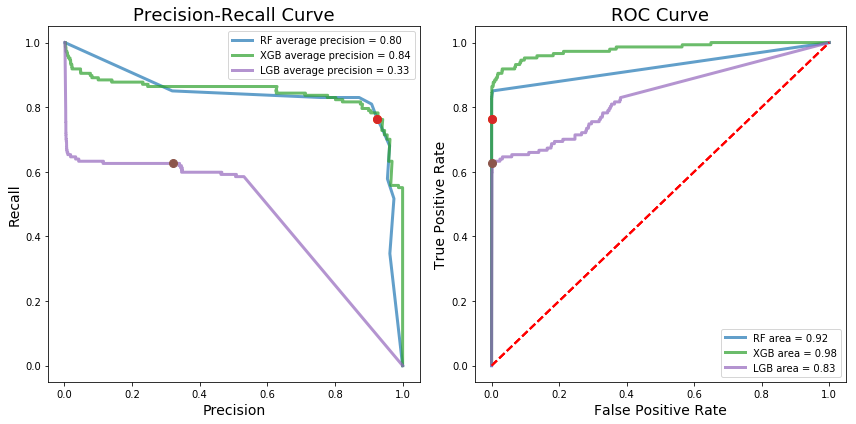

In [10]:
results("Without Balancing")

### Understanding the graph
1. Average precision calculated here is the area under the precision-recall curve which is also called as average precision.
2. The dot in the graph are the default threshold values which is always equal to 0.5 for trees.

#### Results:
1. As expected, xgboost performed well for imbalanced dataset as boosting methods provide higher weights to minority classes. 2. Besides, for highly imbalanced data, even Random forest performed well (which was beyond my expectations).
3. Now, comparing results of RF and XGB, both performed almost same. But there is quite difference between ROC AUC between both. One of the reason for this may be due to the less number of thresholds present in RF.
4. Surprisingly, LGB performed very bad. This may be due to the default parameters present as LGB is quite sensitive to parameter setting.

### NOTE:
You may notice that area using model function (roc_auc_score) and area from compare_models function (roc_curve) are different. This is because I've used y_pred with roc_aur_score and y_pred_prob with roc_curve. Using y_pred_prob is preffered because it increases the number of thresholds(so that more points are availble to plot the graph accurately) whereas y_pred will only give 3 threshold(0, 1, and any value in between 0 and 1).

# Data Balancing Techniques

### 1. Down-Sampling

In [11]:
print("Minority Class =", len(df[df.Class == 1]))

Minority Class = 492


In [12]:
train_majority = df[df.Class == 0]
train_minority = df[df.Class == 1]
train_majority_downsampled = resample(train_majority, replace = False, n_samples = 492, random_state = 0)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

In [13]:
X = train_downsampled.drop(columns = 'Class')
y = train_downsampled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Although now dataset is balanced so boosting models will not give higher weights to the fraulent class, still let's see if it performs well on a balanced dataset.

Down Sampling
######################### RF #########################
Training Accuracy = 0.993
Test Accuracy = 0.922
ROC_AUC_score : 0.922545
[[141   6]
 [ 17 132]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       0.89      0.96      0.92       147
          1       0.96      0.89      0.92       149

avg / total       0.92      0.92      0.92       296

######################### XGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.939
ROC_AUC_score : 0.939369
[[142   5]
 [ 13 136]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       147
          1       0.96      0.91      0.94       149

avg / total       0.94      0.94      0.94       296

######################### LGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.926
ROC_AUC_score : 0.925946
[[142   5]
 [ 17

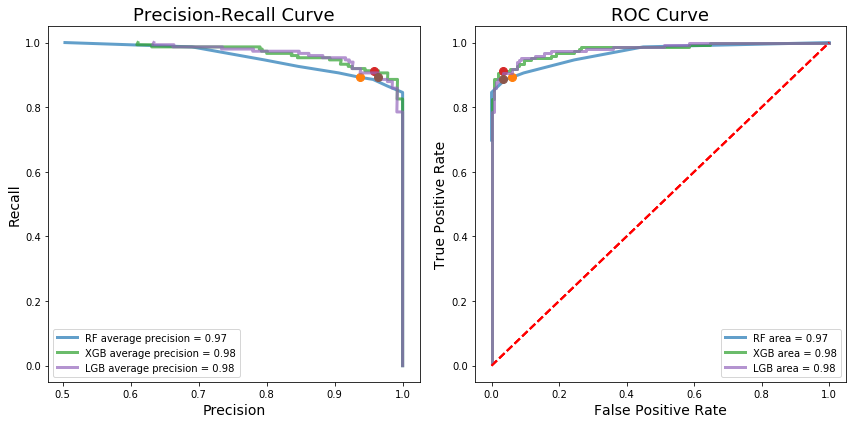

In [14]:
results("Down Sampling")

1. All models performed well but the main disadvantage of down sampling is that it will lose a lot of useful information from the dataset as it is removing more than 99% of non-fraudulent cases from the dataset. Thus, this should not be a practical approach here.

### 2. Up-Sampling

In [15]:
#Note in up sampling, first split the minority class data into train and test set and then up-sample the train data and test it with test data
X = df.drop(columns = 'Class')
y = df['Class']
#First split data into train and test
X_train_us, X_test, y_train_us, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
#Now resample the train data
df_us = pd.concat([X_train_us, y_train_us], axis = 1)
train_majority = df_us[df_us.Class == 0]
train_minority = df_us[df_us.Class == 1]
train_majority.shape, train_minority.shape

((199019, 30), (345, 30))

In [16]:
train_minority_upsampled = resample(train_minority, replace = True, n_samples = 199019, random_state = 0)
print(train_majority.shape, train_minority_upsampled.shape)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
X_train = train_upsampled.drop(columns = 'Class')
y_train = train_upsampled['Class']

(199019, 30) (199019, 30)


Up Sampling
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 1.000
ROC_AUC_score : 0.877528
[[85292     4]
 [   36   111]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.97      0.76      0.85       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.998
Test Accuracy = 0.996
ROC_AUC_score : 0.933346
[[84950   346]
 [   19   128]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.27      0.87      0.41       147

avg / total       1.00      1.00      1.00     85443

######################### LGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.908058
[[

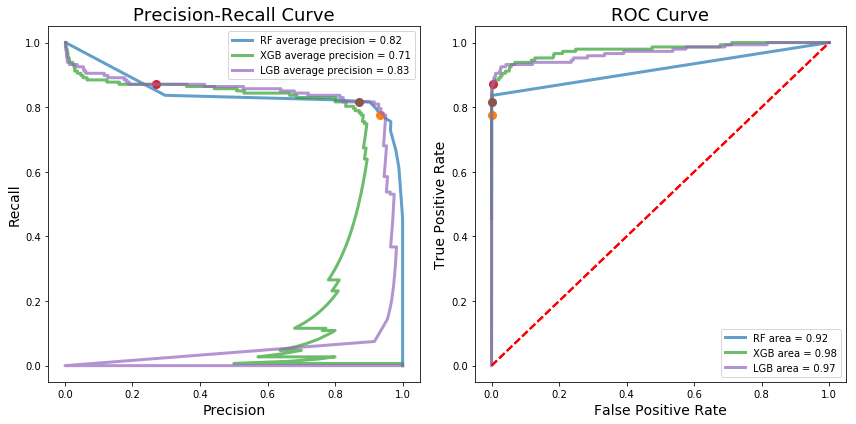

In [17]:
results("Up Sampling")

1. Surprisingly, threshold of XGB is very earlier. But, PR curves resembles same as other models. This means using up sampling, XGB performs well on recall but precision is decreased. I mean that XGB classified less FN and more FP with more than 50% probability. Thus, this increases the recall of XGB.
2. Further looking at PR curves, we can say that all models performes well. As per requirement, one can set threshold and get the required result.

Now, the down side of this method here is up-sampling will restrict learning of models due to repeatation of fraudulent cases so many times and eventually will overfit also. Also it costs us very expensive computationally.

## 3. SMOTE FAMILY

### 3.1 SMOTE Regular

In [18]:
sm = SMOTE(random_state = 0)
X = df.drop(columns = 'Class')
y = df['Class']
X_train_sm, X_test, y_train_sm, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = sm.fit_sample(X_train_sm, y_train_sm)
X_test = np.array(X_test)
y_test = np.array(y_test)

SMOTE Regular
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.891092
[[85285    11]
 [   32   115]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.91      0.78      0.84       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.986
Test Accuracy = 0.991
ROC_AUC_score : 0.934127
[[84503   793]
 [   18   129]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85296
          1       0.14      0.88      0.24       147

avg / total       1.00      0.99      0.99     85443

######################### LGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.914485


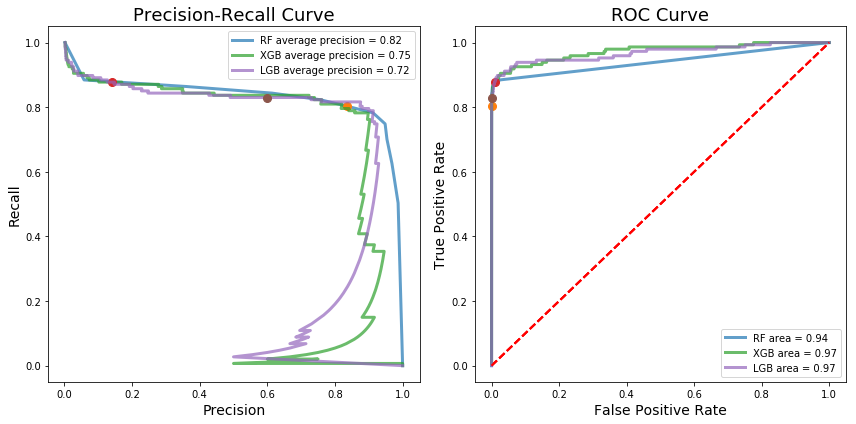

In [19]:
results("SMOTE Regular")

1. Applying SMOTE, RF performed very well.
2. Looking at ROC-AUC curve, boosting performed well. But in real, I will consider RF performing well as compared to boosting methods because RF maintained precision as compared to boosting .

### 3.2 BorderLine SMOTE

In [20]:
sm = SMOTE(random_state = 0, kind = 'borderline1')
X = df.drop(columns = 'Class')
y = df['Class']
X_train_sm, X_test, y_train_sm, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = sm.fit_sample(X_train_sm, y_train_sm)
X_test = np.array(X_test)
y_test = np.array(y_test)

Borderline SMOTE
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.880894
[[85286    10]
 [   35   112]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.92      0.76      0.83       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.998
ROC_AUC_score : 0.920755
[[85123   173]
 [   23   124]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.42      0.84      0.56       147

avg / total       1.00      1.00      1.00     85443

######################### LGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.9043

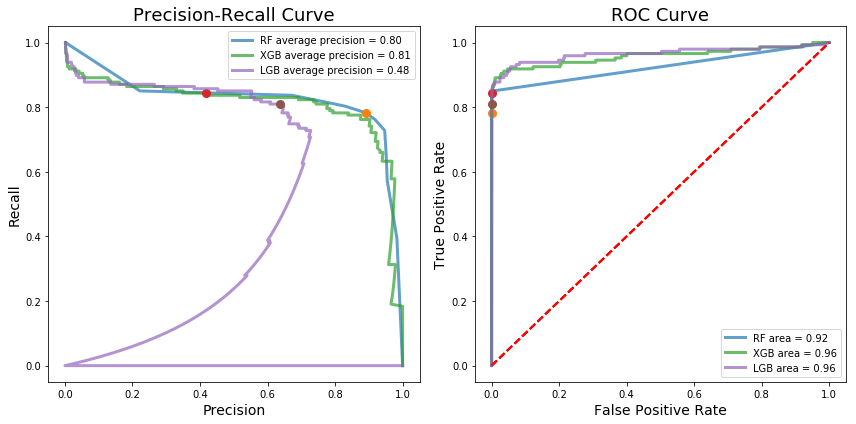

In [21]:
results("Borderline SMOTE")

1. Applying Borderline SMOTE, again RF gave high F1-score.
2. Surprisingly, LGB performed worst looking at PR curves and best according to ROC. 

### 3.3 SVM SMOTE

In [22]:
sm = SMOTE(random_state = 0, kind = 'svm')
X = df.drop(columns = 'Class')
y = df['Class']
X_train_sm, X_test, y_train_sm, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = sm.fit_sample(X_train_sm, y_train_sm)
X_test = np.array(X_test)
y_test = np.array(y_test)

SVM SMOTE
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 1.000
ROC_AUC_score : 0.901290
[[85284    12]
 [   29   118]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.91      0.80      0.85       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.998
ROC_AUC_score : 0.927727
[[85152   144]
 [   21   126]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.47      0.86      0.60       147

avg / total       1.00      1.00      1.00     85443

######################### LGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.914755
[[85

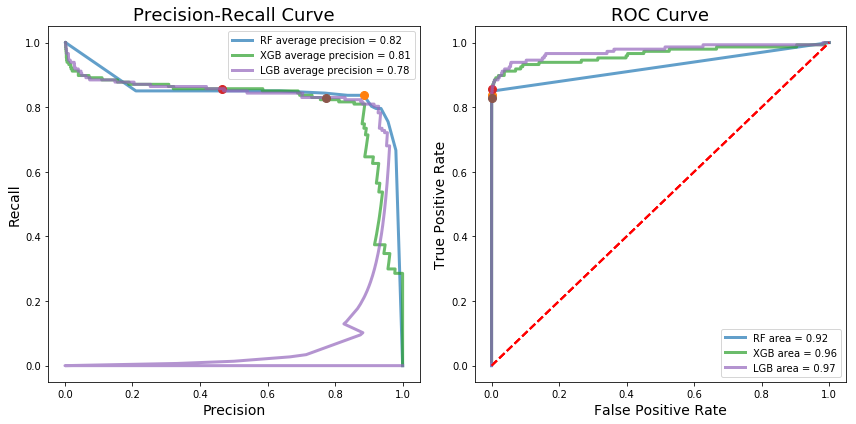

In [23]:
results("SVM SMOTE")

1. Applying SVM SMOTE, all models performed well and gave good F1-score.
2. SVM SMOTE took a lot time to balance the data.

### 4. ADASYN

#### Short Explanation:
ADASYN =  SMOTE + random values between 0 and 1. This makes dataset somewhat more robust.

In [24]:
adasyn = ADASYN(random_state = 0)
X = df.drop(columns = 'Class')
y = df['Class']
X_train_as, X_test, y_train_as, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = adasyn.fit_sample(X_train_as, y_train_as)
X_test = np.array(X_test)
y_test = np.array(y_test)

ADASYN
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.887650
[[85278    18]
 [   33   114]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.86      0.78      0.82       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.980
Test Accuracy = 0.971
ROC_AUC_score : 0.931334
[[82866  2430]
 [   16   131]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     85296
          1       0.05      0.89      0.10       147

avg / total       1.00      0.97      0.98     85443

######################### LGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.998
ROC_AUC_score : 0.893679
[[85146

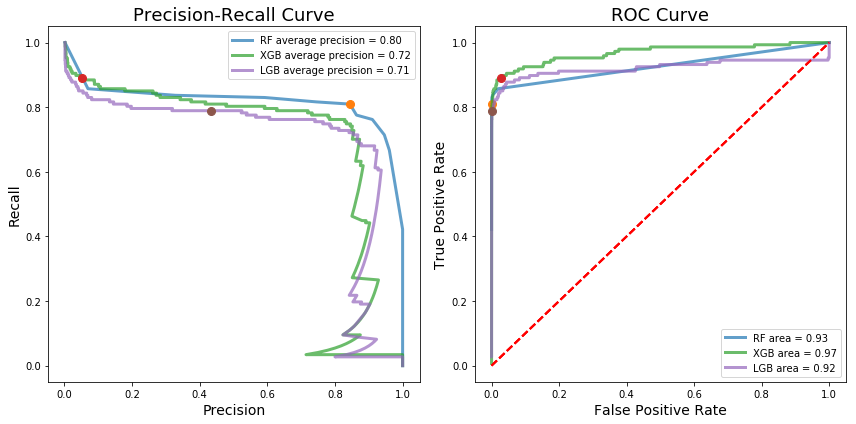

In [25]:
results("ADASYN")

1. All models performed well.

##### RESULTS & CONCLUSIONS:
1. ROC curve for all three models were almost same. PR curve however differentiated somewhat performance based on precision.
2. Random forest performed best when data was balanced with different techniques as it maintained recall and precision with the default threshold and maintained precision as compared to boosting as the threshold was decreasing.
3. For imbalanced data XGB performed slightly well as compared to RF.
4. For balanced data, boosting made predictions with high recall and compromising precision and RF made predictions based on both recall and precision.
5. From PR curves, one can say that models performed well and almost same with SMOTE Regular. User can set threshold to obtain the required result as per the business goal.

##### Limitations:
1. I tried to tune the models with best parameters that give high F1-score but hyperparameter tuning was not possible due to high computational time. This is because the dataset is very large.
2. Due to privacy issue, we don't have original features. This restrics the part of feature engineering.

##### FURTHER WORK:
1. Here I have only compared different data balancing techniques with different models with default parameters. Further, we can look at different parameters of both data balancing techniques and models for better performance.
2. Hyperparameter tuning can provide us better results but its not computationally affordable.
3. One of the limitation of this project was the unavailability of raw credit-card fraud detection dataset i.e, features. If features are available, we can try feature engineering here (polynomials, interactions, etc.).